In [1]:
import pickle as pkl
import os 
import sys
import numpy as np
from xopen import xopen
import json
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

def simMatrix(A: torch.tensor, B: torch.tensor) -> torch.tensor:
    # Assume A and B are your input tensors of shape (N, d)
    # Example: A = torch.randn(N, d)
    #          B = torch.randn(N, d)

    # Step 1: Normalize A and B
    A_norm = A / A.norm(dim=1, keepdim=True)
    B_norm = B / B.norm(dim=1, keepdim=True)

    # Step 2: Compute the dot product
    cosine_similarity_matrix = torch.mm(A_norm, B_norm.transpose(0, 1))

    # The resulting cosine_similarity_matrix is of shape (N, N)
    # and contains values in the range [-1, 1]
    return cosine_similarity_matrix

DATA_PATH = "/home/ubuntu/proj/data/graph/node_cora"
DATA_NAME = "text_graph_cora" # "text_graph_pubmed" #"text_graph_aids" #"text_graph_pubmed" # # 
TRAIN_SPLIT_NAME = 'train_index'
VALID_SPLIT_NAME = 'valid_index'
TEST_SPLIT_NAME = 'test_index'

with open(os.path.join(DATA_PATH, f"{DATA_NAME}.pkl"), 'rb') as f:
    graph = pkl.load(f)
with open(os.path.join(DATA_PATH, f"{TRAIN_SPLIT_NAME}.pkl"), 'rb') as f:
    train_split = pkl.load(f)

with open(os.path.join(DATA_PATH, f"{VALID_SPLIT_NAME}.pkl"), 'rb') as f:
    valid_split = pkl.load(f)
with open(os.path.join(DATA_PATH, f"{TEST_SPLIT_NAME}.pkl"), 'rb') as f:
    test_split = pkl.load(f)

k = 2


/home/ubuntu/anaconda3/envs/graphllm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_nodes=2708, train_id=[1624], val_id=[542], test_id=[542], text_nodes=[2708], text_node_labels=[2708])

In [6]:
train_split

[1,
 2,
 4,
 5,
 6,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 27,
 29,
 30,
 31,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 43,
 45,
 47,
 48,
 50,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 73,
 75,
 76,
 77,
 80,
 82,
 85,
 87,
 89,
 92,
 96,
 98,
 102,
 104,
 106,
 107,
 108,
 109,
 113,
 114,
 117,
 118,
 121,
 122,
 124,
 125,
 128,
 132,
 133,
 135,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 147,
 148,
 149,
 152,
 154,
 155,
 156,
 157,
 159,
 161,
 162,
 169,
 170,
 171,
 172,
 173,
 175,
 177,
 178,
 179,
 182,
 184,
 185,
 186,
 187,
 189,
 190,
 191,
 192,
 194,
 195,
 196,
 198,
 200,
 202,
 203,
 204,
 206,
 208,
 210,
 211,
 212,
 214,
 215,
 217,
 218,
 219,
 220,
 223,
 224,
 227,
 229,
 231,
 232,
 233,
 234,
 240,
 241,
 242,
 245,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 258,
 259,
 260,
 262,
 264,
 265,
 267,
 268,
 270,
 271,
 272,
 276,
 278,
 279,
 283,
 286,
 287,
 289,
 29

In [2]:
all_levels_embedding = dict()
encoder_type = 'bert'
for relevance_type in ['pos','neg','random_1','random_2','random_3']:
    all_levels_embedding[relevance_type] = dict()
    # build 0-order textual-graph
    text_nodes = graph.text_nodes
    edge_index = graph.edge_index
    k = 2
 
    for order in range(0, k+1):
        if encoder_type == 'bert':
            all_levels_embedding[relevance_type][order] = torch.load(os.path.join(DATA_PATH, relevance_type, f"order-{order}-bert.pt")).squeeze(-2)
        else:
            all_levels_embedding[relevance_type][order] = torch.load(os.path.join(DATA_PATH, relevance_type, f"order-{order}.pt")).squeeze(-2)

In [3]:
from gnn import GCN, SAGE
relevance_type = 'pos'
device = torch.device('cuda:0')
num_features = 768 if encoder_type == 'bert' else 1024
hidden_channels = num_features
num_layers = 2
dropout = 0.5
gnn = 'gcn' #'sage' #'gcn'

if gnn == 'gcn':
    model = GCN(num_features, hidden_channels,
                num_features, num_layers,
                dropout).to(device)
elif gnn == 'sage':
    model = SAGE(num_features, hidden_channels,
                num_features, num_layers,
                dropout).to(device)

lr = 1e-3
num_epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [4]:
model.train()
corr_avg = dict()
for t in range(1, num_layers+1):
    corr_avg[t] = [[], []]
for epoch in range(1, 1 + num_epochs):
    optimizer.zero_grad()
    x = all_levels_embedding[relevance_type][0].to(device)
    edge_index = graph.edge_index.to(device)
    embeddings_mapping = model.encode(x, edge_index)
    target = torch.eye(graph.num_nodes, device=device, dtype=torch.float)
    loss_map = {}
    for t in range(1, num_layers+1):
        corrmatrix = simMatrix(
            all_levels_embedding[relevance_type][num_layers].to(device), 
            embeddings_mapping[t]
            )
        corr_avg[t][0].append(float(corrmatrix.diag().mean()))
        corr_avg[t][1].append(float(corrmatrix.mean()))
        loss_map[t] = criterion(corrmatrix.view(-1), target.view(-1))
    loss = torch.sum(torch.stack([loss_map[i] for i in range(1, num_layers+1)]))
    loss.backward()
    optimizer.step()
    print(f"{epoch=}," + ",".join([f"order {i}: {float(loss_map[i]):.4f}" for i in range(1, num_layers+1)]))

epoch=1,order 1: 42804.2344,order 2: 42810.8242
epoch=2,order 1: 42772.5195,order 2: 42770.5703
epoch=3,order 1: 42745.4062,order 2: 42735.5586
epoch=4,order 1: 42722.6875,order 2: 42703.6406
epoch=5,order 1: 42703.8867,order 2: 42675.7852
epoch=6,order 1: 42688.0977,order 2: 42652.7188
epoch=7,order 1: 42674.5000,order 2: 42635.3516
epoch=8,order 1: 42662.5938,order 2: 42621.5078
epoch=9,order 1: 42652.0430,order 2: 42611.0742
epoch=10,order 1: 42642.5859,order 2: 42601.6562
epoch=11,order 1: 42634.0703,order 2: 42593.0391
epoch=12,order 1: 42626.3516,order 2: 42584.9102
epoch=13,order 1: 42619.3828,order 2: 42578.6562
epoch=14,order 1: 42613.0742,order 2: 42573.2812
epoch=15,order 1: 42607.3516,order 2: 42568.0078
epoch=16,order 1: 42602.1211,order 2: 42563.7656
epoch=17,order 1: 42597.3242,order 2: 42559.8711
epoch=18,order 1: 42592.8789,order 2: 42556.8984
epoch=19,order 1: 42588.7383,order 2: 42553.3203
epoch=20,order 1: 42584.8828,order 2: 42549.7109
epoch=21,order 1: 42581.2930,

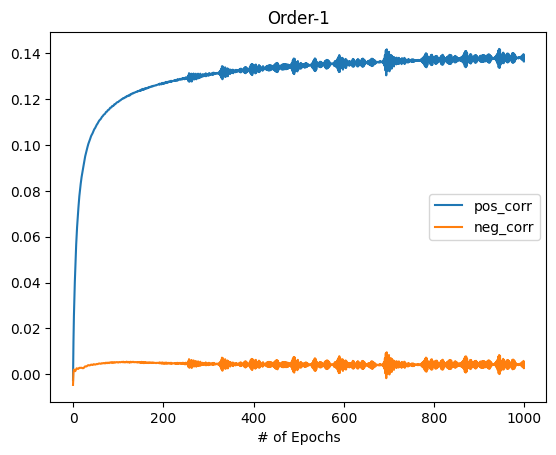

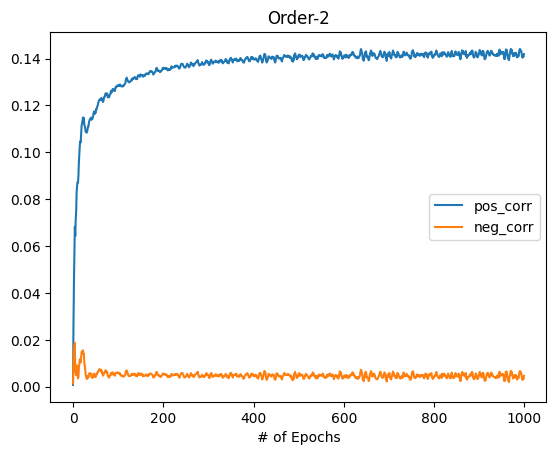

In [5]:
for t in range(1, num_layers+1):
    plt.plot(np.arange(num_epochs), corr_avg[t][0])
    plt.plot(np.arange(num_epochs), corr_avg[t][1])
    plt.legend(['pos_corr', 'neg_corr'])
    plt.xlabel('# of Epochs')
    plt.title(f'Order-{t}')
    plt.show()

In [6]:

SAVE_DIR = "/home/ubuntu/proj/code/axolotl_softprompt/data/cora"
if not os.path.exists(os.path.join(SAVE_DIR, relevance_type)):
    os.makedirs(os.path.join(SAVE_DIR, relevance_type))
embed = all_levels_embedding[relevance_type][0]
train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_textual_order0-{encoder_type}.pt'))
torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_textual_order0-{encoder_type}.pt'))
torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_textual_order0-{encoder_type}.pt'))

for i in range(1, num_layers+1):
    # save textual BERT embeddings
    embed = all_levels_embedding[relevance_type][i]
    train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'train_textual_order{i}-{encoder_type}.pt'))
    torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_textual_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_textual_order{i}-{encoder_type}.pt'))

    # save GNN embeddings
    embed = embeddings_mapping[i].detach().cpu()
    train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'train_{gnn}_order{i}-{encoder_type}.pt'))
    torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_{gnn}_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_{gnn}_order{i}-{encoder_type}.pt'))

In [7]:
'''SAVE_DIR = "/home/ubuntu/proj/code/axolotl_softprompt/data/pubmed"
if not os.path.exists(os.path.join(SAVE_DIR, relevance_type)):
    os.makedirs(os.path.join(SAVE_DIR, relevance_type))
embed = all_levels_embedding[relevance_type][0]
train_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]
train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_textual_order0-{encoder_type}.pt'))
torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'test_textual_order0-{encoder_type}.pt'))

for i in range(1, num_layers+1):
    # save textual BERT embeddings
    embed = all_levels_embedding[relevance_type][i]
    train_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_textual_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'test_textual_order{i}-{encoder_type}.pt'))

    # save GNN embeddings
    embed = embeddings_mapping[i].detach().cpu()
    train_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_{gnn}_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'test_{gnn}_order{i}-{encoder_type}.pt'))'''

'SAVE_DIR = "/home/ubuntu/proj/code/axolotl_softprompt/data/pubmed"\nif not os.path.exists(os.path.join(SAVE_DIR, relevance_type)):\n    os.makedirs(os.path.join(SAVE_DIR, relevance_type))\nembed = all_levels_embedding[relevance_type][0]\ntrain_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]\ntrain_pos_tokens = train_pos_tokens.view(-1, 1, num_features)\ntest_pos_tokens = test_pos_tokens.view(-1, 1, num_features)\ntorch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f\'train_textual_order0-{encoder_type}.pt\'))\ntorch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f\'test_textual_order0-{encoder_type}.pt\'))\n\nfor i in range(1, num_layers+1):\n    # save textual BERT embeddings\n    embed = all_levels_embedding[relevance_type][i]\n    train_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]\n    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)\n    tes